# Vehicle Detection using YOLO tiny 

This is an alternative to the traditional classification method using the computer vision techniques for detecting the cars on a road. In this project, I have used an open source network called YOLO tiny. YOLO tiny actually predicts using the regression model rather than classification. More about YOLO can be found here:
https://pjreddie.com/darknet/yolo/

Below, I have used a code written by me to first detect the lane lines on the road, mostly using OpenCV. Then, the actual code for detecting the vehicles using YOLO tiny begins.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape
keras.backend.set_image_dim_ordering('th')

Using TensorFlow backend.


## The lane finding starts here

** Please note, you can find a more detailed/commented explanation of the code below (till *The vehicle detection using YOLO tiny starts here* here: https://github.com/abylikhsanov/advanced-lane-lines/blob/master/detect_lines.ipynb

In [2]:
def calibrate():
    objp = np.zeros((6*9,3), np.float32) 
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('/Users/abylikhsanov1/AI/carnd/term1/advanced-lane-lines/camera_cal/calibration*.jpg')
    for image in images:
        img = cv2.imread(image)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
        if ret is True:
            imgpoints.append(corners)
            objpoints.append(objp)
            cv2.drawChessboardCorners(gray,(9,6),corners,ret)
    
    img_size = (img.shape[1],img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,img_size,None,None)
    return mtx,dist

In [3]:
def sobel(img,orient='x',ksize=3,thresh=(0,255)):
    if orient is 'x':
        sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=ksize)
    elif orient is 'y':
        sobelx = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=ksize)
    sobel_abs = np.absolute(sobelx)
    sobel_binary = np.uint8(255*sobel_abs/np.max(sobel_abs))
    empty = np.zeros_like(sobel_binary)
    empty[(sobel_binary >= thresh[0]) & (sobel_binary <= thresh[1])] = 1
    return empty

def magnitude(img,ksize=3,thresh=(0,255)):
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=ksize)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=ksize)
    sobel_abs = np.absolute(sobelx+sobely)
    sobel_bin = np.uint8(255*sobel_abs/np.max(sobel_abs))
    empty = np.zeros_like(sobel_bin)
    empty[(sobel_bin >= thresh[0]) & (sobel_bin<= thresh[1])] = 1
    return empty

def direction(img,ksize=3,thresh=(0,255)):
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=ksize)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=ksize)
    sobel_bin = np.arctan(np.absolute(sobelx),np.absolute(sobely))
    empty = np.zeros_like(sobel_bin)
    empty[(sobel_bin >= thresh[0]) & (sobel_bin <= thresh[1])] = 1
    return empty

In [4]:
def threshold(undistorted):
    hls = cv2.cvtColor(undistorted,cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(undistorted,cv2.COLOR_RGB2GRAY)
    luv = cv2.cvtColor(undistorted,cv2.COLOR_RGB2LUV)
    l_thresh = (60, 255) #(170,255)
    s_thresh=(70, 100) # (8,120)
    R_thresh = (180, 255)
    G_thresh = (180, 255)
    lum_thresh = (60,100)


    r_mag = magnitude(undistorted[:,:,0],ksize=3,thresh=R_thresh)
    g_mag = magnitude(undistorted[:,:,1],ksize=3,thresh=G_thresh)
    s_mag = magnitude(hls[:,:,2],ksize=5,thresh=s_thresh)
    l_mag = magnitude(hls[:,:,1],ksize=9,thresh=l_thresh)
    lum_mag = magnitude(luv[:,:,0],ksize=5,thresh=lum_thresh)
    combined_binary = np.zeros_like(r_mag)
    #combined_binary[((r_mag==1) & (g_mag==1))|(s_mag==1)|(l_mag==1)|(lum_mag==1)] = 1
    combined_binary[((r_mag==1) & (g_mag==1))|(s_mag==1)|(lum_mag==1)] = 1

    if len(combined_binary.shape) > 2:
        channel_count = combined_binary.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    vertices = np.int32([[[190,700],[570,450],[700,450],[1200,700]]])
    mask = np.zeros_like(combined_binary)
    cv2.fillPoly(mask, vertices,ignore_mask_color)
    masked_image = cv2.bitwise_and(combined_binary, mask)
   
    offset = 200
    x1 = 200
    x2 = 1100
    src = np.int32([[[190,700],[570,470],[764,470],[1200,700]]])
    #np.float32([[x1,720], [599,446], [680,446], [x2,720]])
    dest = np.float32([[x1+offset,720], [x1+offset,0], [x2-offset,0], [x2-offset,720]])



    
    return masked_image

In [5]:
def warp(masked_image):
    img_size = (masked_image.shape[1],masked_image.shape[0])
    offset = 120
    x1 = 200
    x2 = 1100
    src = np.float32([[190,700], [570,470], [764,470], [1200,700]])
    #np.float32([[x1,720], [599,446], [680,446], [x2,720]])
    dest = np.float32([[x1+offset,720], [x1+offset,0], [x2-offset,0], [x2-offset,720]])
    M = cv2.getPerspectiveTransform(src,dest)
    M_inv = cv2.getPerspectiveTransform(dest,src)
    warped = cv2.warpPerspective(masked_image,M,img_size)
    #fig,(ax1) = plt.subplots(1,1,figsize=(10,5))
    #ax1.imshow(warped)
    
    return warped,M_inv

In [6]:
def fit(warped):
    from scipy.stats import linregress
    global best_right
    global best_left
    global count
    histogram = np.sum(warped[int(warped.shape[0]/2):,:],axis=0)
    out_img = warped
    #fig,(ax1) = plt.subplots(1,1,figsize=(10,5))
    #ax1.plot(histogram)

    #In order to fit the polynomial for the lines, I will divide the image by 2 on x axis, to seperate left and right lanes
    midpoint = int(histogram.shape[0]/2)
    left_side = np.argmax(histogram[:midpoint]) # Getting the most dense pixel region at x axis, argmax returns the index
    right_side = np.argmax(histogram[midpoint:]) + midpoint# Getting the most dense pixel region at x axis right side
    
    # As the maximum Y value is 720, I will choose to divide it to 9 windows
    left_side_start = left_side
    right_side_start = right_side #In order to use those values for the curvature calculation
    constant_val = right_side_start-left_side_start
    windows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/windows) # In this code, this is int size of 80 (80 pixels)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero() # Pixel locations where pixel is 1, [1] = x, [0] = y
    nonzeroy = np.array(nonzero[0]) 
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = left_side 
    rightx_current = right_side

    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(windows): # Looping in 9 steps
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height # Loop 1, 0+1 * 80 = 80 px
        win_y_high = warped.shape[0] - window*window_height # Loop 1, 0 px, this is a top value, as y values are from the top to the bottom
        win_xleft_low = left_side - margin # Setting the square boundaries, from the current found lane piece
        win_xleft_high = left_side + margin
        win_xright_low = right_side - margin
        win_xright_high = right_side + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        left_nzero_values = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]  # Getting the pixel locations, where pixel>1
        right_nzero_values = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(left_nzero_values) # Left_lane_inds is the list of pixel locations in that margin box
        right_lane_inds.append(right_nzero_values)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(left_nzero_values) > minpix:
            leftx_current = np.int(np.mean(nonzerox[left_nzero_values]))
        if right_nzero_values.size > minpix:        
            rightx_current = np.int(np.mean(nonzerox[right_nzero_values]))
            

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Fit a second order polynomial to each
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    #if((len(left_lane_inds)==0) | (len(right_lane_inds)==0)):
        #left_fit = previous_left
        #right_fit = previous_right
    #else:
    lefty = nonzeroy[left_lane_inds]
    leftx = nonzerox[left_lane_inds]
    righty = nonzeroy[right_lane_inds]
    rightx = nonzerox[right_lane_inds] 
    slope_l, intercept, r_value, p_value, std_err = linregress(leftx,lefty)
    slope_r, intercept, r_value, p_value, std_err = linregress(rightx,righty)
    #print(slope_l,slope_r)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    if(abs(right_fit[0])< 0.0001):
        best_right = right_fit
        #print(best_right)
    if(abs(left_fit[0])< 0.0001):
        best_left = left_fit
    #print(left_fit,right_fit)

        #print(abs(slope_r-slope_l))
        #if((abs(slope_r-slope_l) > 4)| (right_fit[2]<900)|(right_fit[2]>1030)):
            #print('random')
            #right = np.array([(left_fit[2]+530) + (y**2)*left_fit[0] + np.random.randint(-50, high=51) for y in ploty])
            #right_fit = np.polyfit(ploty,right,2)
   
        #else:
            #right_fit = np.polyfit(righty, rightx, 2)
            #right_fit_inter = right_fit[2]
            
            
        
    
     # Found the best fir polynomial
    if(abs(right_fit[0])> 0.00001):
        right_fit = best_right
        #print(right_fit)
    if(abs(left_fit[0])> 0.00001):
        left_fit = best_left
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img) # Getting the blank image to display the curves


    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+(right_fitx-left_fitx),ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    # Measuring the curve radius

    y_eval = np.max(ploty)
    ym_per_pix = 22/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension m/px
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Calculate the relation to the center:
    camera_position = warped.shape[1]/2
    lane_center = (right_fitx[719] + left_fitx[719])/2
    center_offset_pixels = camera_position - lane_center
    center_offset_meters = center_offset_pixels*xm_per_pix
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #fig,(ax1) = plt.subplots(1,1,figsize=(10,5))
    #ax1.imshow(result)
    #ax1.plot(left_fitx,ploty,color='yellow')
    #ax1.plot(right_fitx,ploty,color='yellow')
    string1 = float(((left_curverad+right_curverad)/2)/1000)
    string2 = float(center_offset_meters)
    
    
    
    
    return result,left_fitx,right_fitx,string1,string2

In [7]:
def unwarp(result,left_fitx,right_fitx,M_inv,undistorted,string1,string2):
    warp_zero = np.zeros_like(result)
    img_size = (result.shape[1],result.shape[0])
    ploty = np.linspace(0, result.shape[0]-1, result.shape[0])
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(warp_zero, np.int_([pts]), (255,0,0))

    unwarped = cv2.warpPerspective(result,M_inv,img_size)

    newwarp = cv2.warpPerspective(warp_zero, M_inv, (result.shape[1], result.shape[0])) 
    # Combine the result with the original image
    final = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    #cv2.putText(final,("Radius = %.2f km" % string1),(200,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,0))
    #cv2.putText(final,("Position from C = %.2f m"% string2),(360,700),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0))
   
    return final

## The vehicle detection using YOLO tiny starts here

The YOLO model divides an image into smaller grids. Then, each grid has number of cells. For this task, I have followed the YOLO principles (paper can be found here: ) and used 7x7 for the single grid (or 49 total cells per grid). This means, that we will get predictions for each 20 classes presented by the YOLO tiny pretrained model for the each cell. That is 20*49 = 980 predictions. Then, the number of boxes to be found is B=2, which means that in the whole grid (49 cells) we will obtain 49*2 = 98 boxes. Finally, the model will give us 4 coordinates, x,y,w,h. Therefore, in each cell we will get 4*2 (4 points in each B-box) = 8 and for the whole grid we get 8*49 = 392 intersection points. Therefore, the whole number (ordered by class predictions, B and intersections) of data we obtain is 980+98+392 = 1,470.

Next, I will create a class Box, in order to store the Box variables, that we will get from the model, in particular: X and Y coordinates relative to the grid cell, Width and Height values of the box, relative to the whole image and the confidence score.

In [8]:
class Box():
    def __init__(self,x=0,y=0,w=0,h=0,c=0):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.c = c
    def prob(self,p):
        self.p = p

Below, you will find the convolutional neural network that has been proposed by the YOLO. The model does not return the predictions for the classes. Instead, it returns an array of 1470 elements (described above) which already holds the box coordinates (that detect the vehicles), classes across the whole image (there are 20 classes) and the confident scores. 

In [9]:
def model_get():
    
    model = Sequential()
    model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Convolution2D(32,3,3,border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Convolution2D(64,3,3,border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Convolution2D(128,3,3,border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Convolution2D(256,3,3,border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Convolution2D(512,3,3,border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Convolution2D(1024,3,3,border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(Convolution2D(1024,3,3,border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(Convolution2D(1024,3,3,border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1470))
    
    return model

As usual, the below code normalises the image values to -1 and 1. Also, it resizes to 3x448x448, as this is the required dimensions for the YOLO network

In [24]:
def resize_normalise(img):
    cropped_img = img[100:650,0:1280,:]
    cropped_img = cv2.resize(cropped_img,(448,448))
    cropped_img =2.0*cropped_img/255.0-1 # To range from -1 to 1
    transposed = np.transpose(cropped_img,(2,0,1))
    return transposed
    

In [11]:
def overlap(x1, w1, x2, w2):
    l1 = x1 - w1 / 2.
    l2 = x2 - w2 / 2.
    left = max(l1, l2)
    r1 = x1 + w1 / 2.
    r2 = x2 + w2 / 2.
    right = min(r1, r2)
    return right - left


def box_iou(a, b):
    # Here, we are finding the total area of intersection of 2 boxes in a cell. 
    w = overlap(a.x, a.w, b.x, b.w) # First, we are looking for the width and height of boxes that are overlaped
    h = overlap(a.y, a.h, b.y, b.h)
    if w < 0 or h < 0:
        area = 0
    area = w * h #If we find these intersections, we calculate the area
    union = a.w * a.h + b.w * b.h - area # Then, we are finding the overall area (union) minus the overlapped area
    
    return area / union # Simply, returning the ratio
    

def detect_cars(model_output, threshold=0.2, sqrt=2, C=20, B=2, S=7):
    car_class = 6 # This is a location of the class "Cars" in the YOLO model
    cells = S*S # A grid consists of SxS cells, or in this case, grid is 7x7 and 49 cells
    classes = C*cells
    boxes = B*cells
    probs = model_output[0:classes] # All values from the array of 1470 (model output) are in this order.
    confs = model_output[classes:(classes+boxes)]
    coords = model_output[(classes+boxes):]
    boxes = []
    # Now I am reshaping the arrays to have a sense
    probs = probs.reshape((cells,C))
    confs = confs.reshape((cells,B))
    coords = coords.reshape((cells,B,4))
    for cell in range(cells): #0-48
        for box in range(B): #0-2
            c = confs[cell,box]
            x = (coords[cell,box,0] + cell % S) / S
            y = (coords[cell,box,1] + cell // S) / S
            w = coords[cell,box,2] ** sqrt
            h = coords[cell,box,3] ** sqrt
            b = Box(x,y,w,h,c)
            p = probs[cell,:] * c
            
            if(p[car_class]>=threshold):
                b.prob(p[car_class])
                boxes.append(b)
    # After getting all the boxes lets sort them in descending order, key here is the probability value
    boxes.sort(key=lambda b: b.p, reverse=True)
    # Now, lets find the overlapping boxes and retain the box with the highest prob. The threshold area of overlapping is 40
    for i in range(len(boxes)):
        box1 = boxes[i]
        for j in range(i+1,len(boxes)):
            box2 = boxes[j]
            if(box_iou(box1,box2) > 0.3):
                box2.p = 0
    new_box = [box for box in boxes if box.p>0]
    
    return new_box

def draw_boxes(boxes,im, dim):
    imgcv1 = im.copy()
    [xmin, xmax] = dim[0]
    [ymin, ymax] = dim[1]
    
    height, width, _ = imgcv1.shape
    for b in boxes:
        w = xmax - xmin
        h = ymax - ymin

        left  = int ((b.x - b.w/2.) * w) + xmin
        right = int ((b.x + b.w/2.) * w) + xmin
        top   = int ((b.y - b.h/2.) * h) + ymin
        bot   = int ((b.y + b.h/2.) * h) + ymin

        if(left <0):
            left = 0
        if(right > width - 1):
            right = width - 1
        if(top < 0):
            top = 0
        if bot>height - 1: 
            bot = height - 1
    
        
        cv2.rectangle(imgcv1, (left, top), (right, bot), (0,255,0), 5)

    return imgcv1

In [12]:
def load_weights(model, yolo_weight_file): # Open source code available from the Darknet
    data = np.fromfile(yolo_weight_file, np.float32)
    data = data[4:]

    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape, bshape = shape
            bia = data[index:index + np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index + np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            layer.set_weights([ker, bia])

model = model_get()
load_weights(model,'yolo-tiny.weights')

In [23]:
def lane_image(img):
    global mtx
    global dist
    undistorted = cv2.undistort(img,mtx,dist,None,mtx)
    masked_image = threshold(undistorted)
    warped,M_inv = warp(masked_image)
    result,left_fitx,right_fitx,string1,string2= fit(warped)
    final = unwarp(result,left_fitx,right_fitx,M_inv,undistorted,string1,string2)
    return final
    

def process_image(image):
    image = lane_image(image)
    transposed = np.expand_dims(resize_normalise(image),axis=0)
    batch = model.predict(transposed)
    batch_out = detect_cars(batch[0])
    final = draw_boxes(batch_out, image, ((0,1280),(100,650)))
    return final

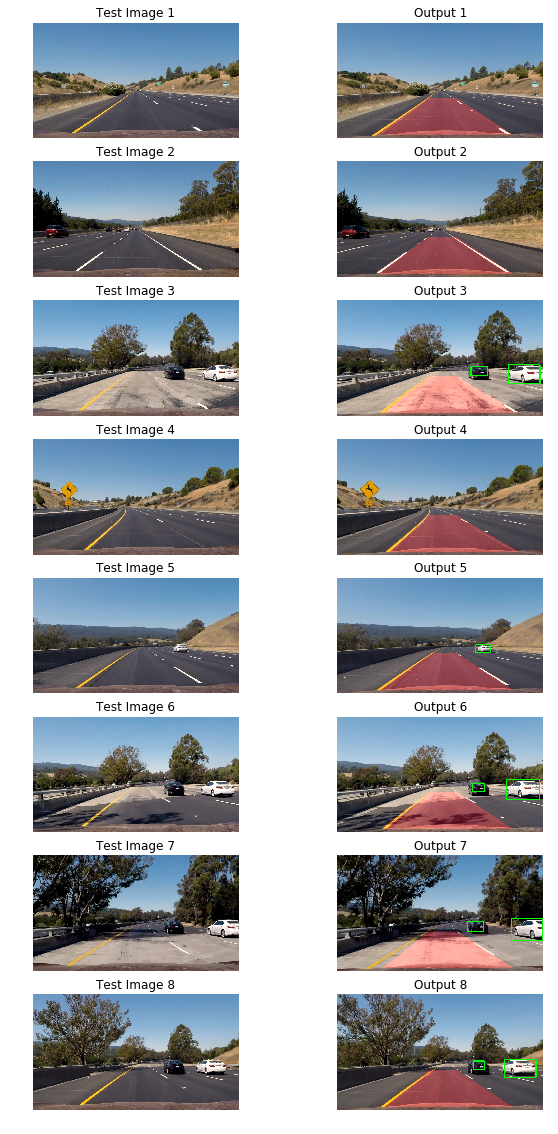

In [22]:
import glob

filenames= glob.glob('test_images/*.jpg')
num_files = len(filenames)
plt.rcParams['figure.figsize'] = (10, 20)

for i in range(num_files):
    image = mpimg.imread(filenames[i])
    final = process_image(image)
    mpimg.imsave("output_images/test%d.jpg" % (i+1), final)
    
    plt.subplot(num_files,2,i*2+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Test Image %d" % (i+1))
    plt.subplot(num_files,2,i*2+2)
    plt.imshow(final)
    plt.axis('off')
    plt.title("Output %d" % (i+1))


In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
mtx,dist = calibrate()
right_fit_inter = 500
best_left = np.array([ -1.07232213e-04,2.06587289e-01,3.05136933e+02],np.float)
best_right = np.array([ -6.80607357e-05,2.32624010e-01,8.16511727e+02],np.float32)
count = 1
white_output = 'output_videos/project_video_test.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_test.mp4
[MoviePy] Writing video output_videos/project_video_test.mp4


 96%|█████████▌| 25/26 [00:20<00:00,  1.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_test.mp4 

CPU times: user 1min 39s, sys: 6.44 s, total: 1min 46s
Wall time: 21.3 s
